In [1]:
import import_ipynb
import corrpre

from keras.models import load_model

from control_data import *
from corr_pred import data_corr, pred_days
from make_df import merge_list
from modeling import *

Using TensorFlow backend.
importing Jupyter notebook from control_data.ipynb
importing Jupyter notebook from corr_pred.ipynb
importing Jupyter notebook from make_df.ipynb
importing Jupyter notebook from modeling.ipynb


In [78]:
lg_data = pd.read_csv('data/066570.csv', index_col=0)
lg_data

,종가,거래량,기관매매량,외국인매매량,외국인보유율
2009-12-04,115500.0,2173892.0,148804.0,441274.0,27.64
2009-12-07,116500.0,1480237.0,-178243.0,455106.0,27.94
2009-12-08,116500.0,1052500.0,-103475.0,254921.0,28.11
2009-12-09,117500.0,1060857.0,-109753.0,138751.0,28.21
2009-12-10,117500.0,1484562.0,-150623.0,70291.0,28.26
...,...,...,...,...,...
2020-01-17,69200.0,464204.0,-89757.0,11089.0,33.77
2020-01-20,71200.0,894609.0,89928.0,249277.0,33.94
2020-01-21,70100.0,379059.0,-30571.0,-17604.0,34.09
2020-01-22,70400.0,546215.0,64709.0,-73675.0,34.08


In [79]:
df = lg_data
corr = data_corr(df, y = -1)
corr

['y: 외국인보유율',
 'x: 종가',
 LinregressResult(slope=0.00019754502625637797, intercept=11.269676308608796, rvalue=0.573299174699053, pvalue=1.9316448402787148e-218, stderr=5.64879696093616e-06)]

In [80]:
x_train, x_test, y_train, y_test = set_data(df, test_rate = 0.1)
prices, foreign_rate, p_figs, a_figs = set_data(df, values = True)

In [81]:
len(x_train), len(x_test)

(2241, 249)

In [85]:
model = Sequential()
model.add(LSTM(2, return_sequences = True, input_shape = (10, 2)))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 2)             40        
_________________________________________________________________
lstm_17 (LSTM)               (None, 10, 64)            17152     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 50,281
Trainable params: 50,281
Non-trainable params: 0
_________________________________________________________________


In [28]:
fit = model.fit(x_train, y_train, 
          validation_split = 0.2, 
          batch_size = 1, 
          epochs = 5)

Train on 1792 samples, validate on 449 samples
Epoch 1/5
 133/1792 [=>............................] - ETA: 54s - loss: 0.0117

KeyboardInterrupt: 

In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 2)             40        
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            17152     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 50,281
Trainable params: 50,281
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.predict(x_train)

array([[ 1.9786956 ],
       [ 2.0379562 ],
       [ 2.051477  ],
       ...,
       [-0.5255447 ],
       [-0.47596917],
       [-0.52503246]], dtype=float32)

In [52]:
train_pred = to_1d_list(model.predict(x_train))
test_pred = to_1d_list(model.predict(x_test))

d_train_pred = denormalize(train_pred, p_figs)
d_test_pred = denormalize(test_pred, p_figs)
d_last_pred = pred_days(
    model, prices, foreign_rate, p_figs, a_figs, corr[2][:2], days = 4)

d_test_pred_added = [d_train_pred[-1]] + d_test_pred + [d_last_pred[0][0]]
d_last_pred = d_last_pred[0]

empty = len(prices) - (len(d_train_pred) + len(d_test_pred))

print(len(d_train_pred), len(d_test_pred_added), empty)

2241 251 10


In [53]:
result_df = merge_list(
    df, empty, prices, d_train_pred, d_test_pred_added, d_last_pred, len(d_test_pred_added)
    )

result_df

,real,trained,tested,pred
2009-12-04,115500.0,NaN,NaN,NaN
2009-12-07,116500.0,NaN,NaN,NaN
2009-12-08,116500.0,NaN,NaN,NaN
2009-12-09,117500.0,NaN,NaN,NaN
2009-12-10,117500.0,NaN,NaN,NaN
...,...,...,...,...
2020-01-22,70400.0,NaN,68470.0,NaN
2020-01-23,69000.0,NaN,66270.0,66270.0
D+1,NaN,NaN,NaN,71430.0
D+2,NaN,NaN,NaN,77550.0


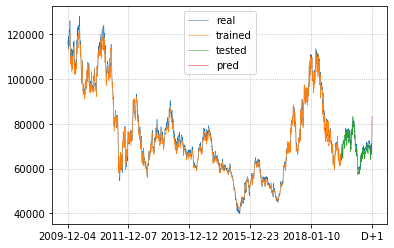

In [54]:
result_df.plot(linewidth = '.5')
plt.grid(ls = ':')
# plt.xticks(np.arange(min(prices), max(prices), step = 0.2))
plt.autoscale(tight = False)

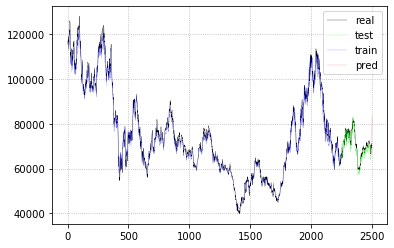

In [55]:
plt.plot(list(result_df[result_df.columns[0]]), 'black', linewidth = '.3')
plt.plot(list(result_df[result_df.columns[2]]), 'lime', linewidth = '.3', alpha = 0.5)
plt.plot(list(result_df[result_df.columns[1]]), 'blue', linewidth = '.3', alpha = 0.5)
plt.plot(list(result_df[result_df.columns[3]]), 'red', linewidth = '.3', alpha = 0.5)
# x축 idx 수정 가능한지?
plt.grid(ls = ':')
plt.legend(['real', 'test', 'train', 'pred'])

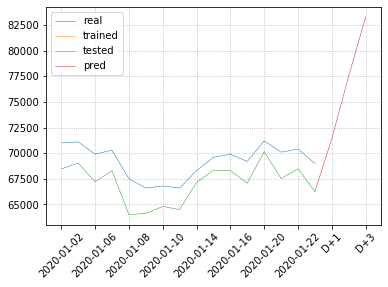

In [56]:
result_df['2019-12.31':].plot(linewidth = '.5')
plt.grid(ls = ':')
# plt.xticks(np.arange(min(prices), max(prices), step = 0.2))
plt.xticks(rotation = 45)
plt.autoscale(tight = False)

In [67]:
pred_100days = pred_days(model, prices, foreign_rate, p_figs, a_figs, corr[2][:2], days = 1000)[0]
pred_100days

[66270.0,
 71430.0,
 77550.0,
 83290.0,
 87310.0,
 88920.0,
 88300.0,
 86060.0,
 82940.0,
 79650.0,
 76940.0,
 75510.0,
 75610.0,
 76740.0,
 77940.0,
 78500.0,
 78310.0,
 77630.0,
 76780.0,
 76030.0,
 75500.0,
 75220.0,
 75100.0,
 75030.0,
 74930.0,
 74750.0,
 74490.0,
 74210.0,
 73920.0,
 73650.0,
 73400.0,
 73170.0,
 72960.0,
 72740.0,
 72510.0,
 72280.0,
 72030.0,
 71780.0,
 71540.0,
 71300.0,
 71060.0,
 70800.0,
 70540.0,
 70290.0,
 70020.0,
 69750.0,
 69470.0,
 69190.0,
 68900.0,
 68610.0,
 68310.0,
 68010.0,
 67700.0,
 67380.0,
 67040.0,
 66710.0,
 66360.0,
 66010.0,
 65650.0,
 65290.0,
 64920.0,
 64550.0,
 64170.0,
 63780.0,
 63390.0,
 63000.0,
 62600.0,
 62200.0,
 61800.0,
 61400.0,
 61000.0,
 60600.0,
 60200.0,
 59800.0,
 59410.0,
 59020.0,
 58630.0,
 58250.0,
 57880.0,
 57520.0,
 57160.0,
 56810.0,
 56470.0,
 56140.0,
 55820.0,
 55510.0,
 55210.0,
 54920.0,
 54640.0,
 54370.0,
 54110.0,
 53860.0,
 53620.0,
 53400.0,
 53180.0,
 52970.0,
 52770.0,
 52580.0,
 52400.0,
 52230.0,


In [68]:
numlist = [pred_100days[x+1] - pred_100days[x] for x in range(len(pred_100days)-1)]
numlist

[5160.0,
 6120.0,
 5740.0,
 4020.0,
 1610.0,
 -620.0,
 -2240.0,
 -3120.0,
 -3290.0,
 -2710.0,
 -1430.0,
 100.0,
 1130.0,
 1200.0,
 560.0,
 -190.0,
 -680.0,
 -850.0,
 -750.0,
 -530.0,
 -280.0,
 -120.0,
 -70.0,
 -100.0,
 -180.0,
 -260.0,
 -280.0,
 -290.0,
 -270.0,
 -250.0,
 -230.0,
 -210.0,
 -220.0,
 -230.0,
 -230.0,
 -250.0,
 -250.0,
 -240.0,
 -240.0,
 -240.0,
 -260.0,
 -260.0,
 -250.0,
 -270.0,
 -270.0,
 -280.0,
 -280.0,
 -290.0,
 -290.0,
 -300.0,
 -300.0,
 -310.0,
 -320.0,
 -340.0,
 -330.0,
 -350.0,
 -350.0,
 -360.0,
 -360.0,
 -370.0,
 -370.0,
 -380.0,
 -390.0,
 -390.0,
 -390.0,
 -400.0,
 -400.0,
 -400.0,
 -400.0,
 -400.0,
 -400.0,
 -400.0,
 -400.0,
 -390.0,
 -390.0,
 -390.0,
 -380.0,
 -370.0,
 -360.0,
 -360.0,
 -350.0,
 -340.0,
 -330.0,
 -320.0,
 -310.0,
 -300.0,
 -290.0,
 -280.0,
 -270.0,
 -260.0,
 -250.0,
 -240.0,
 -220.0,
 -220.0,
 -210.0,
 -200.0,
 -190.0,
 -180.0,
 -170.0,
 -160.0,
 -160.0,
 -140.0,
 -140.0,
 -130.0,
 -120.0,
 -120.0,
 -110.0,
 -110.0,
 -100.0,
 -90.0,
 -90.0,
 